上下文扩展技术：从提示到分层上下文
===================================

本笔记本介绍了将基础提示词演变为分层、信息丰富上下文的实用策略，以提升大语言模型（LLM）的性能。重点在于实际的上下文工程：如何有策略地添加和结构化上下文层，并系统性地衡量对令牌使用和输出质量的影响。

涵盖的关键概念：
1. 将最小提示转化为扩展、丰富的上下文结构
2. 上下文分层和组合式提示工程原则
3. 随着上下文增长，令牌使用量的定量测量
4. 模型输出质量的定性评估
5. 上下文迭代优化的方法

用法：
    # 在 Jupyter 或 Colab 中：
    %run 02_context_expansion.py
    # 或
    # 逐步运行笔记本单元，修改上下文层并观察效果

注意事项：
    - 每个部分都是模块化的——可通过编辑和运行不同的上下文层进行实验。
    - 跟踪额外上下文如何改变成本（令牌数）和性能（输出质量）。
    - 可作为开发高级上下文工程协议的实践基础。

In [11]:
## 环境设置与前置条件

import os
import json
import time
import tiktoken  # OpenAI 的分词器
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any, Optional, Union
from IPython.display import display, Markdown

from client import chat_completion
import tiktoken

# 分词计数器设置
tokenizer = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """使用相应分词器统计字符串中的分词数。"""
    if tokenizer:
        return len(tokenizer.encode(text))
    # 非 OpenAI 模型的备用方案（粗略估算）
    return len(text.split()) * 1.3  # 粗略估算

def measure_latency(func, *args, **kwargs) -> Tuple[Any, float]:
    """测量函数的执行时间。"""
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time
    

## 1. 理解上下文扩展

def calculate_metrics(prompt: str, response: str, latency: float) -> Dict[str, float]:
    """计算提示-回复对的关键指标。"""
    prompt_tokens = count_tokens(prompt)
    response_tokens = count_tokens(response)
    
    # 简单分词效率（回复分词数 / 提示分词数）
    token_efficiency = response_tokens / prompt_tokens if prompt_tokens > 0 else 0
    
    # 每千分词的延迟
    latency_per_1k = (latency / prompt_tokens) * 1000 if prompt_tokens > 0 else 0
    
    return {
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "token_efficiency": token_efficiency,
        "latency": latency,
        "latency_per_1k": latency_per_1k
    }

def generate_response(prompt: str) -> Tuple[str, float]:
    """使用 client.chat_completion 从大语言模型生成回复并测量延迟。"""
    start_time = time.time()
    response = chat_completion(prompt)
    latency = time.time() - start_time
    return response, latency


In [2]:
## 2. 实验：上下文扩展技术

# 基础提示（原子）
base_prompt = "写一段关于气候变化的段落。"

# 扩展提示变体（分子）
expanded_prompts = {
    "base": base_prompt,
    
    "with_role": """你是一名具有气候系统专业知识的环境科学家。
写一段关于气候变化的段落。""",
    
    "with_examples": """写一段关于气候变化的段落。

示例 1：
气候变化是指温度和天气模式的长期变化。自 19 世纪以来，人类活动一直是气候变化的主要驱动力，主要原因是燃烧煤炭、石油和天然气等化石燃料，这会产生吸热气体。

示例 2：
全球气候变化体现在极端天气事件频率增加、海平面上升和野生动物种群变化等方面。科学界普遍认为人类活动是主要原因。""",
    
    "with_constraints": """写一段关于气候变化的段落。
- 包含至少一个带有数字的科学事实
- 提及原因和影响
- 以号召行动结尾
- 保持语气信息丰富但易于理解""",
    
    "with_audience": """为刚开始学习环境科学的高中生写一段关于气候变化的段落。使用清晰的解释和贴近生活的例子。""",
    
    "comprehensive": """你是一名具有气候系统专业知识的环境科学家。

为刚开始学习环境科学的高中生写一段关于气候变化的段落。使用清晰的解释和贴近生活的例子。

写作指南：
- 包含至少一个带有数字的科学事实
- 提及原因和影响
- 以号召行动结尾
- 保持语气信息丰富但易于理解

语气和结构示例：
“海洋酸化是指海水吸收大气中的二氧化碳，导致 pH 值下降。自工业革命以来，海洋 pH 值已下降 0.1 单位，酸度增加了 30%。这影响了海洋生物，尤其是贝类和珊瑚礁，因为它们形成壳和骨骼的能力受到了影响。科学家预测，如果排放量保持当前水平，到 2100 年海洋酸度可能增加 150%，这将对海洋生态系统造成严重破坏。通过使用公共交通等简单行动减少碳足迹，我们可以帮助保护这些重要的海洋栖息地。”
"""
}

# 运行实验
results = {}
responses = {}

for name, prompt in expanded_prompts.items():
    print(f"测试提示：{name}")
    response, latency = generate_response(prompt)
    responses[name] = response
    metrics = calculate_metrics(prompt, response, latency)
    results[name] = metrics
    print(f"  提示分词数：{metrics['prompt_tokens']}")
    print(f"  回复分词数：{metrics['response_tokens']}")
    print(f"  延迟：{metrics['latency']:.2f}秒")
    print("-" * 40)


测试提示：base
  提示分词数：16
  回复分词数：222
  延迟：4.80秒
----------------------------------------
测试提示：with_role
  提示分词数：40
  回复分词数：293
  延迟：2.55秒
----------------------------------------
测试提示：with_examples
  提示分词数：192
  回复分词数：215
  延迟：2.34秒
----------------------------------------
测试提示：with_constraints
  提示分词数：72
  回复分词数：228
  延迟：2.12秒
----------------------------------------
测试提示：with_audience
  提示分词数：49
  回复分词数：278
  延迟：12.83秒
----------------------------------------
测试提示：comprehensive
  提示分词数：375
  回复分词数：319
  延迟：2.34秒
----------------------------------------


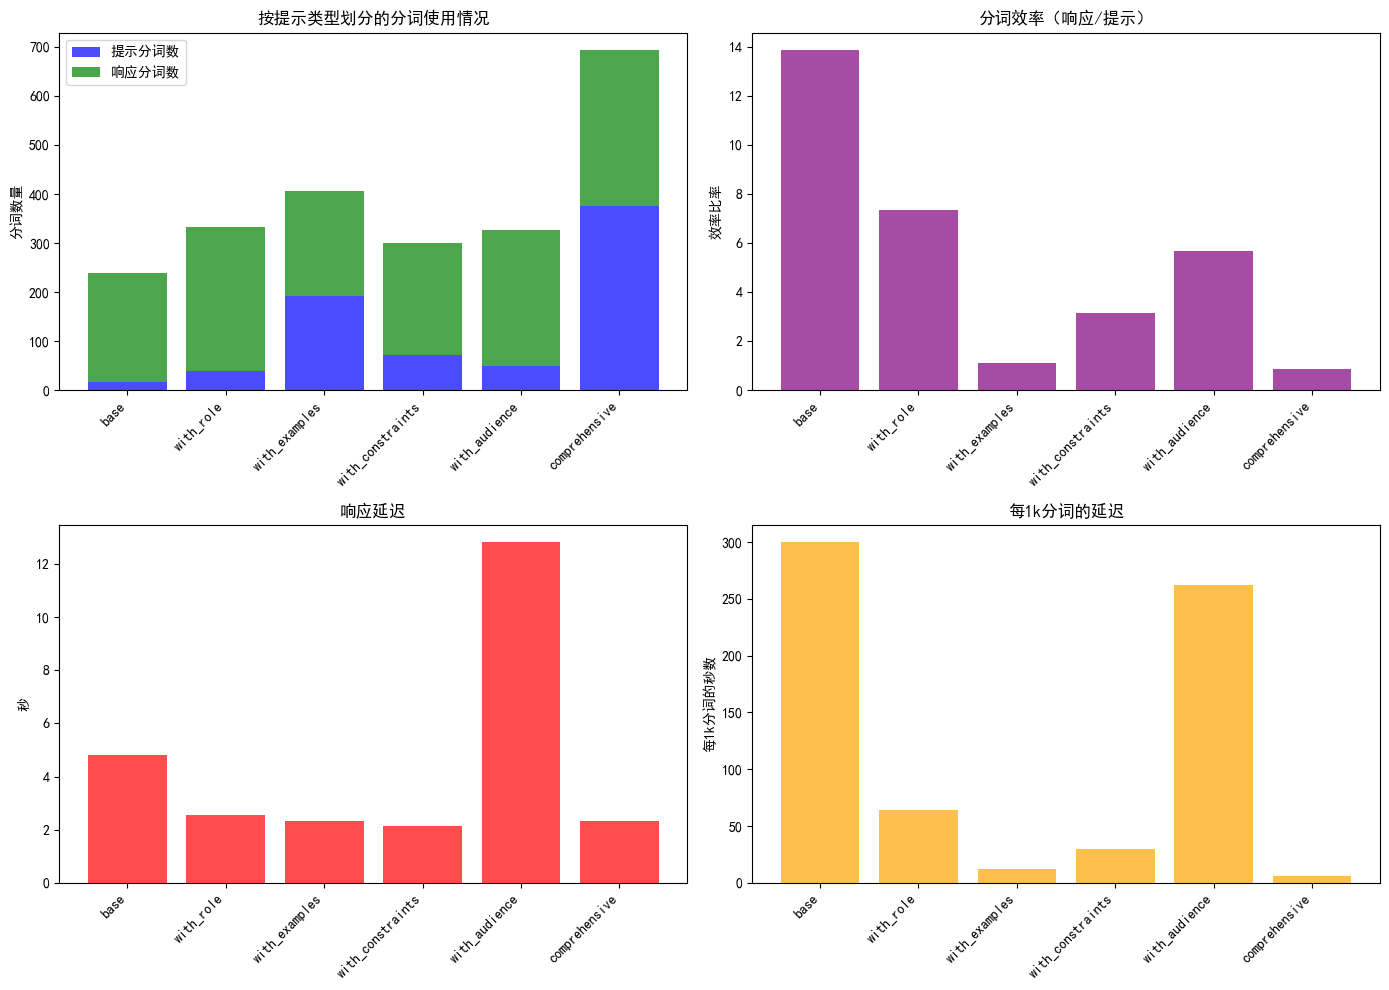

In [4]:
import warnings

## 3. 可视化和分析结果

# 准备可视化数据
prompt_types = list(results.keys())
prompt_tokens = [results[k]['prompt_tokens'] for k in prompt_types]
response_tokens = [results[k]['response_tokens'] for k in prompt_types]
latencies = [results[k]['latency'] for k in prompt_types]

# 创建包含多个子图的图形
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 设置中文字体
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 图1：分词使用情况
axes[0, 0].bar(prompt_types, prompt_tokens, label='提示分词数', alpha=0.7, color='blue')
axes[0, 0].bar(prompt_types, response_tokens, bottom=prompt_tokens, label='响应分词数', alpha=0.7, color='green')
axes[0, 0].set_title('按提示类型划分的分词使用情况')
axes[0, 0].set_ylabel('分词数量')
axes[0, 0].legend()
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# 图2：分词效率（响应分词数 / 提示分词数）
token_efficiency = [results[k]['token_efficiency'] for k in prompt_types]
axes[0, 1].bar(prompt_types, token_efficiency, color='purple', alpha=0.7)
axes[0, 1].set_title('分词效率（响应/提示）')
axes[0, 1].set_ylabel('效率比率')
plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# 图3：延迟
axes[1, 0].bar(prompt_types, latencies, color='red', alpha=0.7)
axes[1, 0].set_title('响应延迟')
axes[1, 0].set_ylabel('秒')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# 图4：每1k分词的延迟
latency_per_1k = [results[k]['latency_per_1k'] for k in prompt_types]
axes[1, 1].bar(prompt_types, latency_per_1k, color='orange', alpha=0.7)
axes[1, 1].set_title('每1k分词的延迟')
axes[1, 1].set_ylabel('每1k分词的秒数')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [12]:
## 4. 质量分析

# 检查实际回复以评估质量差异：

for name, response in responses.items():
    print(f"=== {name} 提示的回复 ===")
    display(Markdown(response))
    print("\n" + "=" * 80 + "\n")


=== base 提示的回复 ===


气候变化是当前全球面临的重大挑战之一，主要由人类活动引发的温室气体排放导致地球气温不断上升。这种变化不仅引发极端天气事件频发，如洪水、干旱和热浪，还对生态系统和生物多样性造成严重影响。气候变化还威胁到人类的粮食安全、水资源供应以及健康状况。为了减缓气候变化的进程，各国需要加强合作，推动清洁能源发展，减少碳排放，同时公众也应增强环保意识，共同保护我们的地球家园。



=== with_role 提示的回复 ===


气候变化是指地球气候系统在较长时间尺度上发生的显著变化，主要表现为全球平均气温的升高、极端天气事件的频发以及海平面的上升。这一现象主要由人类活动引起，尤其是大量燃烧化石燃料释放温室气体（如二氧化碳和甲烷），增强了温室效应，导致地表能量平衡失衡。气候变化不仅影响生态系统的稳定性，还威胁农业生产、水资源安全和人类健康，甚至加剧全球贫困和社会不稳定。因此，科学界和政策制定者强调通过减少温室气体排放、推动可再生能源发展及增强适应能力来缓解和应对气候变化的紧迫性和必要性。



=== with_examples 提示的回复 ===


气候变化是指地球气候系统在长期尺度上的变化，尤其表现为全球气温的持续上升。主要原因是人类大量排放温室气体，如二氧化碳和甲烷，这些气体吸收并滞留热量，导致温室效应增强。气候变化带来了极端天气频发、冰川融化和海平面上升等严重影响，威胁生态环境和人类社会的可持续发展。为了减缓气候变化，全球各国正积极推动能源结构转型和减少碳排放。



=== with_constraints 提示的回复 ===


气候变化主要是由于工业革命以来大量燃烧化石燃料，导致大气中的二氧化碳浓度从约280 ppm增加到超过420 ppm。温室气体的增加使全球平均气温在过去一个世纪上升了约1摄氏度，这引发了极端天气事件频发、冰川融化和海平面上升等严重影响。若不采取有效措施，未来几十年气候变化将加剧，威胁生态系统和人类生活安全。因此，我们每个人都应积极减少碳足迹，采用绿色能源，共同保护地球家园。



=== with_audience 提示的回复 ===


气候变化是指地球上的气温和天气模式发生长期的变化。简单来说，就是我们的地球变得越来越热了。这主要是因为人类活动，比如烧煤、开车和砍伐森林，释放了很多二氧化碳和其他温室气体，这些气体像一层毯子一样包裹着地球，导致热量无法散发出去。生活中，我们可以看到的例子有：夏天变得比以前更热，冬天少了很多雪，极端天气事件比如暴雨、干旱和台风也越来越频繁。气候变化不仅影响我们的生活环境，还威胁动植物的生存，所以保护环境、减少污染对每个人来说都非常重要。



=== comprehensive 提示的回复 ===


气候变化是指地球大气和气温长期发生的变化。自工业革命以来，全球平均气温已经上升了约1.2摄氏度，这主要是由于人类燃烧煤炭、石油等化石燃料，释放大量二氧化碳和其他温室气体。这些气体会像毯子一样困住热量，导致地球变暖。气候变暖带来了许多影响，比如极端天气频发，冰川融化，海平面上升，威胁沿海城市的安全。举个例子，北极的夏季冰盖面积比40年前减少了约40%，影响了许多依赖海冰生存的动物，如北极熊。我们每个人都能通过节约用电、减少汽车使用和支持环保政策，为减缓气候变化贡献力量，共同保护地球的未来。

# 5. 上下文扩展模式

基于我们的实验，我们可以识别出几种有效的上下文扩展模式：

1. **角色分配**：定义模型应该扮演的角色
2. **少样本示例**：提供示例输出来引导响应格式和质量
3. **约束定义**：为响应设置边界和要求
4. **受众说明**：明确响应的目标受众
5. **综合上下文**：战略性地组合多个上下文元素

让我们将这些模式形式化为一个可重用的模板：

In [17]:

def create_expanded_context(
    base_prompt: str, 
    role: Optional[str] = None,
    examples: Optional[List[str]] = None,
    constraints: Optional[List[str]] = None,
    audience: Optional[str] = None,
    tone: Optional[str] = None,
    output_format: Optional[str] = None
) -> str:
    """
    根据基础提示和可选组件创建扩展的上下文。
    
    参数：
        base_prompt: 核心指令或问题
        role: 模型应该扮演的角色
        examples: 用于引导模型的示例输出列表
        constraints: 要求或边界列表
        audience: 输出的目标受众
        tone: 期望的响应语气
        output_format: 特定的格式要求
        
    返回：
        扩展后的上下文字符串
    """
    context_parts = []
    
    # 如果提供了角色，则添加
    if role:
        context_parts.append(f"你是{role}。")
    
    # 添加基础提示
    context_parts.append(base_prompt)
    
    # 如果提供了受众，则添加
    if audience:
        context_parts.append(f"你的回应应该适合{audience}。")
    
    # 如果提供了语气，则添加
    if tone:
        context_parts.append(f"在你的回应中使用{tone}的语气。")
    
    # 如果提供了输出格式，则添加
    if output_format:
        context_parts.append(f"将你的回应格式化为{output_format}。")
    
    # 如果提供了约束，则添加
    if constraints and len(constraints) > 0:
        context_parts.append("要求：")
        for constraint in constraints:
            context_parts.append(f"- {constraint}")
    
    # 如果提供了示例，则添加
    if examples and len(examples) > 0:
        context_parts.append("示例：")
        for i, example in enumerate(examples, 1):
            context_parts.append(f"示例 {i}：\n{example}")
    
    # 用适当的间距连接所有部分
    expanded_context = "\n\n".join(context_parts)
    
    return expanded_context


# 让我们用一个新的提示来测试我们的模板：

# 测试我们的模板
new_base_prompt = "解释光合作用是如何工作的。"

new_expanded_context = create_expanded_context(
    base_prompt=new_base_prompt,
    role="一位有15年教学经验的生物老师",
    audience="初中学生",
    tone="充满热情和教育性",
    constraints=[
        "使用植物工厂的类比",
        "提及叶绿素的作用",
        "解释对地球生态系统的重要性",
        "保持在200字以内"
    ],
    examples=[
        """光合作用就像植物内部的一个小工厂。正如工厂需要原材料、能源和工人来制造产品一样，植物需要二氧化碳、水、阳光和叶绿素来制造葡萄糖（糖）和氧气。\n阳光是能源，叶绿素分子是捕获这种能源的工人，而二氧化碳和水是原材料。\n工厂的产品是葡萄糖，植物用它来生长和储存能量，以及氧气，它被释放到空气中供我们这样的动物呼吸。\n这个过程对地球上的生命至关重要，因为它提供了我们需要的氧气，并从大气中清除二氧化碳。"""
    ]
)

print("模板生成的扩展上下文：")
print("-" * 80)
print(new_expanded_context)
print("-" * 80)
print(f"分词数量：{count_tokens(new_expanded_context)}")

# 使用我们的扩展上下文生成响应
response, latency = generate_response(new_expanded_context)
metrics = calculate_metrics(new_expanded_context, response, latency)

print("\n响应：")
print("-" * 80)
display(Markdown(response))
print("-" * 80)
print(f"响应分词数：{metrics['response_tokens']}")
print(f"延迟：{metrics['latency']:.2f}秒")


模板生成的扩展上下文：
--------------------------------------------------------------------------------
你是一位有15年教学经验的生物老师。

解释光合作用是如何工作的。

你的回应应该适合初中学生。

在你的回应中使用充满热情和教育性的语气。

要求：

- 使用植物工厂的类比

- 提及叶绿素的作用

- 解释对地球生态系统的重要性

- 保持在200字以内

示例：

示例 1：
光合作用就像植物内部的一个小工厂。正如工厂需要原材料、能源和工人来制造产品一样，植物需要二氧化碳、水、阳光和叶绿素来制造葡萄糖（糖）和氧气。
阳光是能源，叶绿素分子是捕获这种能源的工人，而二氧化碳和水是原材料。
工厂的产品是葡萄糖，植物用它来生长和储存能量，以及氧气，它被释放到空气中供我们这样的动物呼吸。
这个过程对地球上的生命至关重要，因为它提供了我们需要的氧气，并从大气中清除二氧化碳。
--------------------------------------------------------------------------------
分词数量：370

响应：
--------------------------------------------------------------------------------


光合作用就像植物体内的一个神奇工厂！这个工厂需要三样原料：阳光、水和二氧化碳。首先，叶子里的叶绿素像勤劳的工人一样，专门吸收阳光的能量。接着，这些能量帮助植物把水和二氧化碳变成它们最喜欢的“食物”——葡萄糖，这是一种糖，能给植物提供生长的能量。另外，工厂还会生产氧气，作为“副产品”释放到空气中。对我们来说，这氧气非常宝贵，因为我们和许多动物都依赖它呼吸。光合作用不仅让植物健康成长，还保护了地球的空气质量，是维持生态平衡和生命延续的重要力量！是不是很神奇呢？

--------------------------------------------------------------------------------
响应分词数：296
延迟：3.22秒


In [19]:
## 6. 高级上下文扩展：层优化

# 在实际应用中，我们需要找到上下文丰富性和分词效率之间的最佳平衡。让我们用系统化的方法来实验上下文层优化：


def test_layered_contexts(base_prompt: str, context_layers: Dict[str, str]) -> Dict[str, Dict]:
    """
    测试不同的上下文层组合以找到最优配置。
    
    参数：
        base_prompt: 核心指令
        context_layers: 层名称 -> 层内容的字典
        
    返回：
        包含每个测试配置指标的结果字典
    """
    layer_results = {}
    
    # 单独测试基础提示
    print("测试基础提示...")
    base_response, base_latency = generate_response(base_prompt)
    layer_results["基础"] = {
        "提示": base_prompt,
        "响应": base_response,
        **calculate_metrics(base_prompt, base_response, base_latency)
    }
    
    # 测试每个层单独添加到基础提示
    for layer_name, layer_content in context_layers.items():
        combined_prompt = f"{base_prompt}\n\n{layer_content}"
        print(f"测试基础 + {layer_name}...")
        response, latency = generate_response(combined_prompt)
        layer_results[f"基础+{layer_name}"] = {
            "提示": combined_prompt,
            "响应": response,
            **calculate_metrics(combined_prompt, response, latency)
        }
    
    # 测试所有层的组合
    all_layers = "\n\n".join(context_layers.values())
    full_prompt = f"{base_prompt}\n\n{all_layers}"
    print("测试所有层的组合...")
    full_response, full_latency = generate_response(full_prompt)
    layer_results["所有层"] = {
        "提示": full_prompt,
        "响应": full_response,
        **calculate_metrics(full_prompt, full_response, full_latency)
    }
    
    return layer_results

# 定义一个基础提示和独立的上下文层
layer_test_prompt = "编写代码来实现一个简单的天气应用。"

context_layers = {
    "角色": "你是一位具有全栈开发和UI/UX设计专业知识的高级软件工程师。",
    
    "需求": """需求：
- 应用应该显示当前温度、天气状况和未来3天的预报
- 应该允许用户通过城市名称搜索天气
- 应该有一个干净、响应式的界面
- 应用应该优雅地处理错误状态""",
    
    "技术栈": """技术规范：
- 使用HTML、CSS和原生JavaScript（不使用框架）
- 使用OpenWeatherMap API获取天气数据
- 所有代码都应该有良好的注释并遵循最佳实践
- 包括HTML结构和JavaScript功能""",
    
    "示例": """示例结构（但请改进这个版本）：
```html
<!DOCTYPE html>
<html>
<head>
    <title>Weather App</title>
    <link rel="stylesheet" href="styles.css">
</head>
<body>
    <div class="container">
        <h1>Weather App</h1>
        <div class="search">
            <input type="text" placeholder="Enter city name">
            <button>Search</button>
        </div>
        <div class="weather-display">
            <!-- Weather data will be displayed here -->
        </div>
    </div>
    <script src="app.js"></script>
</body>
</html>
```"""
}

# Run the layer optimization test
layer_test_results = test_layered_contexts(layer_test_prompt, context_layers)


测试基础提示...
测试基础 + 角色...
测试基础 + 需求...
测试基础 + 技术栈...
测试基础 + 示例...
测试所有层的组合...


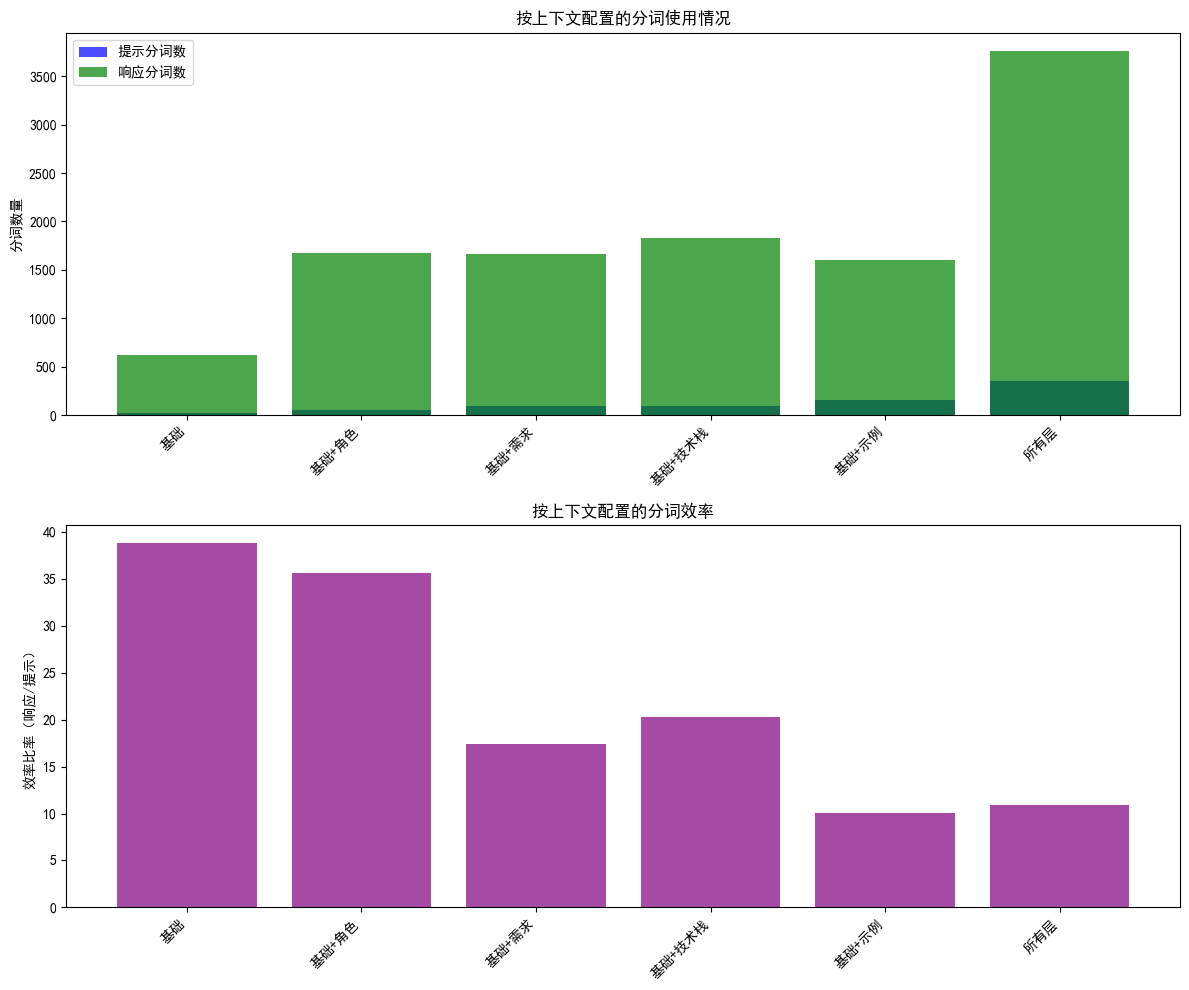

最高分词效率的配置：基础
效率比率：38.75


In [20]:
# 让我们可视化层优化测试的结果：

# 提取可视化数据
config_names = list(layer_test_results.keys())
prompt_sizes = [layer_test_results[k]['prompt_tokens'] for k in config_names]
response_sizes = [layer_test_results[k]['response_tokens'] for k in config_names]
efficiencies = [layer_test_results[k]['token_efficiency'] for k in config_names]

# 创建可视化
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 设置中文字体
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 图1：按配置的分词使用情况
axes[0].bar(config_names, prompt_sizes, label='提示分词数', alpha=0.7, color='blue')
axes[0].bar(config_names, response_sizes, label='响应分词数', alpha=0.7, color='green')
axes[0].set_title('按上下文配置的分词使用情况')
axes[0].set_ylabel('分词数量')
axes[0].legend()
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

# 图2：按配置的分词效率
axes[1].bar(config_names, efficiencies, color='purple', alpha=0.7)
axes[1].set_title('按上下文配置的分词效率')
axes[1].set_ylabel('效率比率（响应/提示）')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 识别最高效的配置
most_efficient = max(config_names, key=lambda x: layer_test_results[x]['token_efficiency'])
print(f"最高分词效率的配置：{most_efficient}")
print(f"效率比率：{layer_test_results[most_efficient]['token_efficiency']:.2f}")


In [22]:
# ## 7. 上下文压缩技术

# 随着我们扩展上下文，通常需要优化分词使用。让我们探索一些上下文压缩技术：


def compress_context(context: str, technique: str = 'summarize') -> str:
    """
    应用不同的压缩技术来减少分词使用，同时保留含义。
    
    参数：
        context: 要压缩的上下文
        technique: 要使用的压缩技术 (summarize, keywords, bullet)
        
    返回：
        压缩后的上下文
    """
    if technique == 'summarize':
        # 使用大语言模型来总结上下文
        prompt = f"""以简洁的方式总结以下上下文，保留所有关键信息
但使用更少的词汇。专注于基本指令和细节：

{context}"""
        compressed, _ = generate_response(prompt)
        return compressed
    
    elif technique == 'keywords':
        # 提取关键术语和短语
        prompt = f"""从这个上下文中提取最重要的关键词、短语和指令：

{context}

将你的回复格式化为用逗号分隔的基本术语和短语列表。"""
        keywords, _ = generate_response(prompt)
        return keywords
    
    elif technique == 'bullet':
        # 转换为要点
        prompt = f"""将这个上下文转换为简洁、结构化的要点列表，
用最少的词汇捕获所有基本信息：

{context}"""
        bullets, _ = generate_response(prompt)
        return bullets
    
    else:
        return context  # 不压缩

# 在我们的综合示例上测试压缩
original_context = expanded_prompts["comprehensive"]
print(f"原始上下文分词数：{count_tokens(original_context)}")

for technique in ['summarize', 'keywords', 'bullet']:
    compressed = compress_context(original_context, technique)
    compression_ratio = count_tokens(compressed) / count_tokens(original_context)
    print(f"\n{technique.upper()} 压缩：")
    print("-" * 80)
    display(Markdown(compressed))
    print("-" * 80)
    print(f"压缩后分词数：{count_tokens(compressed)}")
    print(f"压缩比率：{compression_ratio:.2f} (越低越好)")


原始上下文分词数：375

SUMMARIZE 压缩：
--------------------------------------------------------------------------------


气候变化是指地球气温因人类活动增加温室气体（如二氧化碳）而上升。自1880年以来，全球平均气温已升高约1.2摄氏度，导致冰川融化和极端天气增多。温室气体主要来自燃烧化石燃料，如汽车和工厂排放。气候变化影响农业、水资源和生物多样性，威胁人类生活。我们可以通过节能、减少塑料使用和植树等行动减缓气候变化，保护地球未来。

--------------------------------------------------------------------------------
压缩后分词数：201
压缩比率：0.54 (越低越好)

KEYWORDS 压缩：
--------------------------------------------------------------------------------


气候系统专业知识, 环境科学家, 高中生, 气候变化, 清晰解释, 贴近生活例子, 科学事实, 带数字, 原因, 影响, 号召行动, 信息丰富语气, 易于理解语气, 海洋酸化, 二氧化碳吸收, pH值下降, 工业革命, 海洋pH下降0.1单位, 酸度增加30%, 海洋生物影响, 贝类, 珊瑚礁, 壳和骨骼形成受影响, 预测2100年酸度增加150%, 海洋生态系统破坏, 减少碳足迹, 使用公共交通

--------------------------------------------------------------------------------
压缩后分词数：237
压缩比率：0.63 (越低越好)

BULLET 压缩：
--------------------------------------------------------------------------------


- 角色设定：环境科学家，气候系统专业  
- 读者对象：刚开始学习环境科学的高中生  
- 内容要求：  
  • 主题：气候变化  
  • 包含至少一个带数字的科学事实  
  • 解释原因  
  • 描述影响  
  • 使用贴近日常生活的例子  
  • 语言清晰、易懂  
  • 语气信息丰富但不复杂  
  • 结尾含行动号召  
- 示例结构：  
  1. 定义或现象说明  
  2. 数据支持  
  3. 理由说明（原因）  
  4. 影响描述  
  5. 号召行动

--------------------------------------------------------------------------------
压缩后分词数：213
压缩比率：0.57 (越低越好)


In [23]:

## 8. 上下文修剪：删除无用的内容

# 有时添加上下文层并不能提高性能。让我们实现一个方法来测量和修剪不必要的上下文：

def evaluate_response_quality(prompt: str, response: str, criteria: List[str]) -> float:
    """
    使用 LLM 评估响应基于特定标准的质量。
    
    参数：
        prompt: 生成响应的提示词
        response: 要评估的响应
        criteria: 用于评估的标准列表
        
    返回：
        从 0.0 到 1.0 的质量分数
    """
    criteria_list = "\n".join([f"- {c}" for c in criteria])
    eval_prompt = f"""评估以下提示词对应响应的质量。
    
提示词：
{prompt}

响应：
{response}

请基于以下标准进行评估：
{criteria_list}

对于每个标准，评分范围为 0-10，然后提供一个从 0.0 到 1.0 的总体分数，其中
1.0 表示完美，0.0 表示完全不合格。请按以下格式回复：

标准 1：[分数] - [简短评论]
标准 2：[分数] - [简短评论]
...
总体分数：[0.0-1.0]
"""
    
    evaluation, _ = generate_response(eval_prompt)
    
    # 提取总体分数
    try:
        # 查找"总体分数："后面出现的最后一个十进制数
        import re
        score_match = re.findall(r"总体分数:\s*([0-9]*\.?[0-9]+)", evaluation)
        if score_match:
            return float(score_match[-1])
        else:
            return 0.5  # 解析失败时的默认值
    except:
        return 0.5  # 解析失败时的默认值

def prune_context_layers(base_prompt: str, layers: Dict[str, str], criteria: List[str]) -> Tuple[str, Dict]:
    """
    系统地测试和修剪不能提高响应质量的上下文层。
    
    参数：
        base_prompt: 核心指令
        layers: 上下文层名称 -> 内容的字典
        criteria: 响应的评估标准
        
    返回：
        (优化后的提示词，结果字典) 的元组
    """
    print("测试基准...")
    base_response, base_latency = generate_response(base_prompt)
    base_quality = evaluate_response_quality(base_prompt, base_response, criteria)
    
    results = {
        "base": {
            "prompt": base_prompt,
            "response": base_response,
            "quality": base_quality,
            "tokens": count_tokens(base_prompt),
            "latency": base_latency
        }
    }
    
    # 添加所有层
    all_layers_text = "\n\n".join(layers.values())
    full_prompt = f"{base_prompt}\n\n{all_layers_text}"
    print("测试所有层...")
    full_response, full_latency = generate_response(full_prompt)
    full_quality = evaluate_response_quality(full_prompt, full_response, criteria)
    
    results["所有层"] = {
        "prompt": full_prompt,
        "response": full_response,
        "quality": full_quality,
        "tokens": count_tokens(full_prompt),
        "latency": full_latency
    }
    
    # 每次测试移除一个层
    best_quality = full_quality
    best_config = "所有层"
    
    for layer_to_remove in layers.keys():
        remaining_layers = {k: v for k, v in layers.items() if k != layer_to_remove}
        remaining_text = "\n\n".join(remaining_layers.values())
        test_prompt = f"{base_prompt}\n\n{remaining_text}"
        
        print(f"测试移除 '{layer_to_remove}'...")
        test_response, test_latency = generate_response(test_prompt)
        test_quality = evaluate_response_quality(test_prompt, test_response, criteria)
        
        config_name = f"移除_{layer_to_remove}"
        results[config_name] = {
            "prompt": test_prompt,
            "response": test_response,
            "quality": test_quality,
            "tokens": count_tokens(test_prompt),
            "latency": test_latency
        }
        
        # 如果移除一个层能改善或保持质量，更新最佳配置
        if test_quality >= best_quality:
            best_quality = test_quality
            best_config = config_name
    
    # 如果最佳配置是"所有层"，返回完整的提示词
    if best_config == "所有层":
        return full_prompt, results
    
    # 如果移除一个层提高了质量，递归地修剪更多
    if best_config.startswith("移除_"):
        removed_layer = best_config.replace("移除_", "")
        remaining_layers = {k: v for k, v in layers.items() if k != removed_layer}
        print(f"层 '{removed_layer}' 可以被移除。测试进一步修剪...")
        return prune_context_layers(base_prompt, remaining_layers, criteria)
    
    return results[best_config]["prompt"], results

# 测试上下文修剪
pruning_test_prompt = "编写一个关于如何使用 pandas 进行数据分析的教程。"

pruning_layers = {
    "角色": "你是一位拥有 10 年以上 Python 库教学经验的数据科学讲师。",
    
    "受众": "你的受众是理解基本编程概念但没有数据分析经验的 Python 初学者。",
    
    "结构": "使用以下部分构建教程：介绍、安装、加载数据、基本操作、数据清洗、数据可视化和实践示例。",
    
    "风格": "使用友好、对话式的语气。包含带有解释每行代码注释的代码片段。将复杂概念分解为简单的解释。",
    
    "不必要的": "包含有关 pandas 历史及其开发团队的详细信息。提及 pandas 是由 Wes McKinney 在 2008 年在 AQR Capital Management 时创建的。"
}

evaluation_criteria = [
    "完整性 - 涵盖所有基本概念",
    "清晰度 - 以易于理解的方式解释概念",
    "代码质量 - 提供有用、正确的代码示例",
    "初学者友好性 - 假设没有 pandas 的先验知识",
    "实用性 - 包含现实世界的应用"
]

# 取消注释以运行修剪测试（运行需要时间）
# optimized_prompt, pruning_results = prune_context_layers(pruning_test_prompt, pruning_layers, evaluation_criteria)
# 
# print("\n优化后的提示词：")
# print("-" * 80)
# print(optimized_prompt)
# print("-" * 80)
# 
# # 显示每个配置的质量分数
# for config, data in pruning_results.items():
#     print(f"{config}：质量 = {data['quality']:.2f}，分词数 = {data['tokens']}")



In [24]:
# ## 9. 使用检索的上下文扩展

# 对于实际应用，我们经常需要通过从外部来源检索的相关信息来扩展上下文。让我们实现一个简单的检索增强上下文扩展：


def retrieve_relevant_info(query: str, knowledge_base: List[Dict[str, str]]) -> List[str]:
    """
    基于查询从知识库中检索相关信息。
    
    参数：
        query: 搜索查询
        knowledge_base: 包含 'title' 和 'content' 键的字典列表
        
    返回：
        相关信息片段列表
    """
    # 在实际应用中，您会使用向量嵌入和相似性搜索
    # 在这个例子中，我们将使用简单的关键词匹配
    relevant_info = []
    
    query_terms = set(query.lower().split())
    
    for item in knowledge_base:
        content = item['content'].lower()
        title = item['title'].lower()
        
        # 计算匹配项
        matches = sum(1 for term in query_terms if term in content or term in title)
        
        if matches > 0:
            relevant_info.append(item['content'])
    
    return relevant_info[:3]  # 返回前3个匹配项

# 示例知识库（在实际应用中，这会大得多）
sample_knowledge_base = [
    {
        "title": "Pandas简介",
        "content": "Pandas是一个快速、强大、灵活且易于使用的开源数据分析和处理工具，构建在Python编程语言之上。主要特性包括DataFrame对象、缺失数据处理和数据对齐。"
    },
    {
        "title": "Pandas安装",
        "content": "要安装pandas，运行：pip install pandas。对于Anaconda用户，pandas预先安装。您可以使用以下方式导入pandas：import pandas as pd"
    },
    {
        "title": "在Pandas中加载数据",
        "content": "Pandas可以从各种来源读取数据，包括CSV、Excel、SQL数据库和JSON。示例：df = pd.read_csv('data.csv')"
    },
    {
        "title": "使用Pandas进行数据清洗",
        "content": "Pandas提供处理缺失数据的函数，如dropna()和fillna()。它还提供删除重复项和转换数据的方法。"
    },
    {
        "title": "使用Pandas进行数据可视化",
        "content": "Pandas与matplotlib集成，提供绘图功能。可以使用df.plot()创建简单的图表。对于更复杂的可视化，使用：import matplotlib.pyplot as plt"
    }
]

def create_rag_context(base_prompt: str, query: str, knowledge_base: List[Dict[str, str]]) -> str:
    """
    通过将基础提示与相关信息结合来创建检索增强上下文。
    
    参数：
        base_prompt: 核心指令
        query: 用于搜索相关信息的查询
        knowledge_base: 要搜索的知识库
        
    返回：
        包含检索信息的扩展上下文
    """
    relevant_info = retrieve_relevant_info(query, knowledge_base)
    
    if not relevant_info:
        return base_prompt
    
    # 将检索的信息添加为上下文
    context_block = "相关信息：\n\n" + "\n\n".join(relevant_info)
    
    # 与基础提示结合
    rag_context = f"{base_prompt}\n\n{context_block}"
    
    return rag_context

# 测试检索增强上下文扩展
rag_test_prompt = "编写一个关于如何在pandas中加载数据和处理缺失值的简短教程。"
rag_context = create_rag_context(rag_test_prompt, "pandas加载数据清洗", sample_knowledge_base)

print("检索增强上下文：")
print("-" * 80)
print(rag_context)
print("-" * 80)
print(f"分词数量：{count_tokens(rag_context)}")

# 使用RAG上下文生成响应
rag_response, rag_latency = generate_response(rag_context)
print("\nRAG响应：")
print("-" * 80)
print(rag_response)
print("-" * 80)


检索增强上下文：
--------------------------------------------------------------------------------
编写一个关于如何在pandas中加载数据和处理缺失值的简短教程。
--------------------------------------------------------------------------------
分词数量：28

RAG响应：
--------------------------------------------------------------------------------
# Pandas中加载数据与处理缺失值简短教程

Pandas是Python中非常流行的数据处理库，下面介绍如何使用Pandas加载数据以及处理缺失值的基本方法。

## 1. 导入pandas库

```python
import pandas as pd
```

## 2. 加载数据

通常使用`pd.read_csv()`方法读取CSV文件：

```python
df = pd.read_csv('data.csv')
```

Pandas还支持多种格式，如Excel、JSON等：

```python
df_excel = pd.read_excel('data.xlsx')
df_json = pd.read_json('data.json')
```

## 3. 查看数据的基本信息

```python
print(df.head())      # 显示前5行数据
print(df.info())      # 查看数据类型及缺失情况
print(df.describe())  # 查看数值列的统计信息
```

## 4. 处理缺失值

### 4.1 检测缺失值

```python
print(df.isnull().sum())  # 每列缺失值数量
```

### 4.2 删除缺失值

删除含有缺失值的行或列：

```python
df_drop_rows = df.dropna()         # 删除含缺失值的行
df_drop_cols = df.dropna(axis=1)   # 删除含缺失值的列
```

### 4.3 填

## 10. 结论：上下文扩展最佳实践

基于我们的实验，以下是有效上下文扩展的关键最佳实践：

1. **从最简开始**：以可能有效的最简单提示为起点
2. **衡量影响**：跟踪每次扩展的分词使用量、延迟和质量指标
3. **战略分层**：以独立、模块化的层次添加上下文，并可单独测试
4. **尽可能压缩**：使用摘要、要点或关键词来减少分词使用
5. **无情修剪**：移除不能提升响应质量的上下文层
6. **使用模板**：为不同的上下文扩展模式创建可复用模板
7. **考虑检索**：对于大型知识库，使用检索动态扩展上下文
8. **平衡具体性与通用性**：更具体的上下文可减少幻觉，但可能限制创造力

### 上下文扩展决策模板

```
1. 明确核心目标  
   ↓  
2. 创建最简提示  
   ↓  
3. 测量基线性能  
   ↓  
4. 识别潜在的上下文层  
   │  - 角色分配  
   │  - 少样本示例  
   │  - 约束/需求  
   │  - 受众说明  
   │  - 语气/风格指导  
   ↓  
5. 单独测试每一层  
   ↓  
6. 组合有潜力的层  
   ↓  
7. 衡量影响：  
   │  - 分词使用量  
   │  - 响应质量  
   │  - 延迟  
   ↓  
8. 修剪不必要的层  
   ↓  
9. 压缩剩余上下文  
   ↓  
10. 最终优化（分词效率）
```

请记住：目标不是创建最大的上下文，而是优化质量与效率的最有效上下文。
